# Network Traffic Classification Project

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
import joblib
import warnings
import os

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Set Matplotlib and Seaborn styles
plt.style.use('fivethirtyeight')
sns.set_palette('colorblind')

# Display settings for better readability
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 200)

In [2]:
# 1. Data Loading and Initial Inspection

file_paths = {
    'normal': 'normal_data.csv',
    'ddos1': 'ddos_attack.csv',
    'ddos2': 'ddos_attack2.csv',
    'portscan': 'port_scaning.csv'
}

# Function to load and inspect each dataset
def load_and_inspect_data(file_paths):
    dataframes = {}
    
    for key, path in file_paths.items():
        try:
            # Check if file exists
            if not os.path.exists(path):
                print(f"Warning: File {path} does not exist. Skipping...")
                continue
                
            # Load data
            df = pd.read_csv(path)
            print(f"\nLoaded {key} dataset: {path}")
            print(f"Shape: {df.shape}")
            
            # Quick inspection of data types and missing values
            print("\nData types:")
            print(df.dtypes.value_counts())
            
            # Check for missing values
            missing = df.isnull().sum()
            if missing.sum() > 0:
                print("\nMissing values:")
                print(missing[missing > 0])
            else:
                print("\nNo missing values found.")
            
            # Store the dataframe
            dataframes[key] = df
            
        except Exception as e:
            print(f"Error loading {path}: {str(e)}")
    
    return dataframes

# Load all datasets
dataframes = load_and_inspect_data(file_paths)



Loaded normal dataset: normal_data.csv
Shape: (17270, 21)

Data types:
float64    14
int64       6
object      1
Name: count, dtype: int64

No missing values found.

Loaded ddos1 dataset: ddos_attack.csv
Shape: (317674, 21)

Data types:
float64    14
int64       6
object      1
Name: count, dtype: int64

No missing values found.

Loaded ddos2 dataset: ddos_attack2.csv
Shape: (671, 21)

Data types:
float64    14
int64       6
object      1
Name: count, dtype: int64

No missing values found.

Loaded portscan dataset: port_scaning.csv
Shape: (849, 21)

Data types:
float64    14
int64       6
object      1
Name: count, dtype: int64

No missing values found.


Combined data shape: (336464, 21)

Label distribution:
Label
ddos            318345
normal           17270
port scaning       849
Name: count, dtype: int64


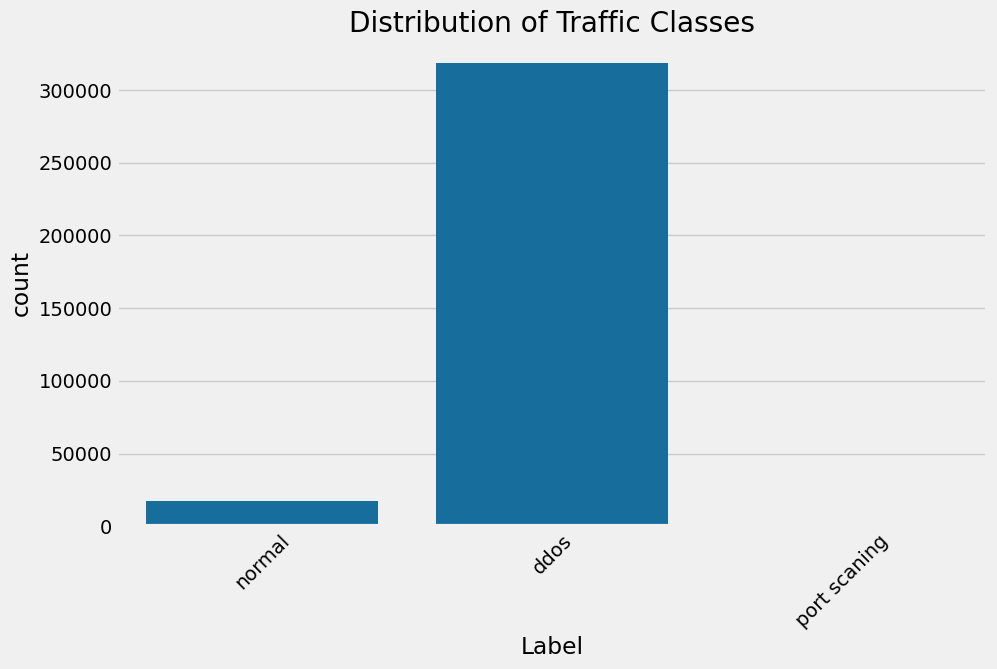

In [3]:
# 2. Data Preparation and Cleaning

# Combine all dataframes
def combine_data(dataframes):
    if not dataframes:
        raise ValueError("No dataframes loaded successfully")
    
    combined_df = pd.concat(dataframes.values(), ignore_index=True)
    print(f"Combined data shape: {combined_df.shape}")
    
    # Check for label distribution
    print("\nLabel distribution:")
    label_dist = combined_df['Label'].value_counts()
    print(label_dist)
    
    # Visualize label distribution
    plt.figure(figsize=(10, 6))
    sns.countplot(x='Label', data=combined_df)
    plt.title('Distribution of Traffic Classes')
    plt.xticks(rotation=45)
    plt.show()
    
    return combined_df

combined_df = combine_data(dataframes)

In [4]:
#Handling missing values
for col in combined_df.columns:
    if combined_df[col].isnull().sum() > 0:
        # Replace nulls with median for numeric columns
        if pd.api.types.is_numeric_dtype(combined_df[col]):
            combined_df[col] = combined_df[col].fillna(combined_df[col].median())
            print(f"Filled missing values in {col} with median")

# Look for infinite values
print("\nChecking for infinite values...")
has_inf = False
for col in combined_df.select_dtypes(include=[np.number]).columns:
    inf_count = np.isinf(combined_df[col]).sum()
    if inf_count > 0:
        has_inf = True
        print(f"Column {col} has {inf_count} infinite values")
        # Replace inf with large number
        combined_df[col] = combined_df[col].replace([np.inf, -np.inf], np.nan)
        combined_df[col] = combined_df[col].fillna(combined_df[col].median())
        print(f"Replaced infinites in {col} with median")

if not has_inf:
    print("No infinite values found.")



Checking for infinite values...
No infinite values found.



Basic statistics:
                                 count          mean           std           min           25%           50%           75%           max
 Fwd Packet Length Mean       336464.0  9.134448e+01  2.111685e+02  5.400000e+01  5.400000e+01  5.400000e+01  5.400000e+01  1.514000e+03
 Fwd Packet Length Max        336464.0  9.912164e+01  2.480202e+02  5.400000e+01  5.400000e+01  5.400000e+01  5.400000e+01  1.514000e+03
 Avg Fwd Segment Size         336464.0  9.134448e+01  2.111685e+02  5.400000e+01  5.400000e+01  5.400000e+01  5.400000e+01  1.514000e+03
 Subflow Fwd Bytes            336464.0  9.210967e+02  5.922581e+03  5.400000e+01  5.400000e+01  5.400000e+01  1.080000e+02  6.024000e+04
Total Length of Fwd Packets   336464.0  9.210967e+02  5.922581e+03  5.400000e+01  5.400000e+01  5.400000e+01  1.080000e+02  6.024000e+04
 Flow IAT Max                 336464.0  1.233794e-03  2.905903e-02  0.000000e+00  0.000000e+00  0.000000e+00  6.008148e-05  8.000851e+00
 Average Packet Size  

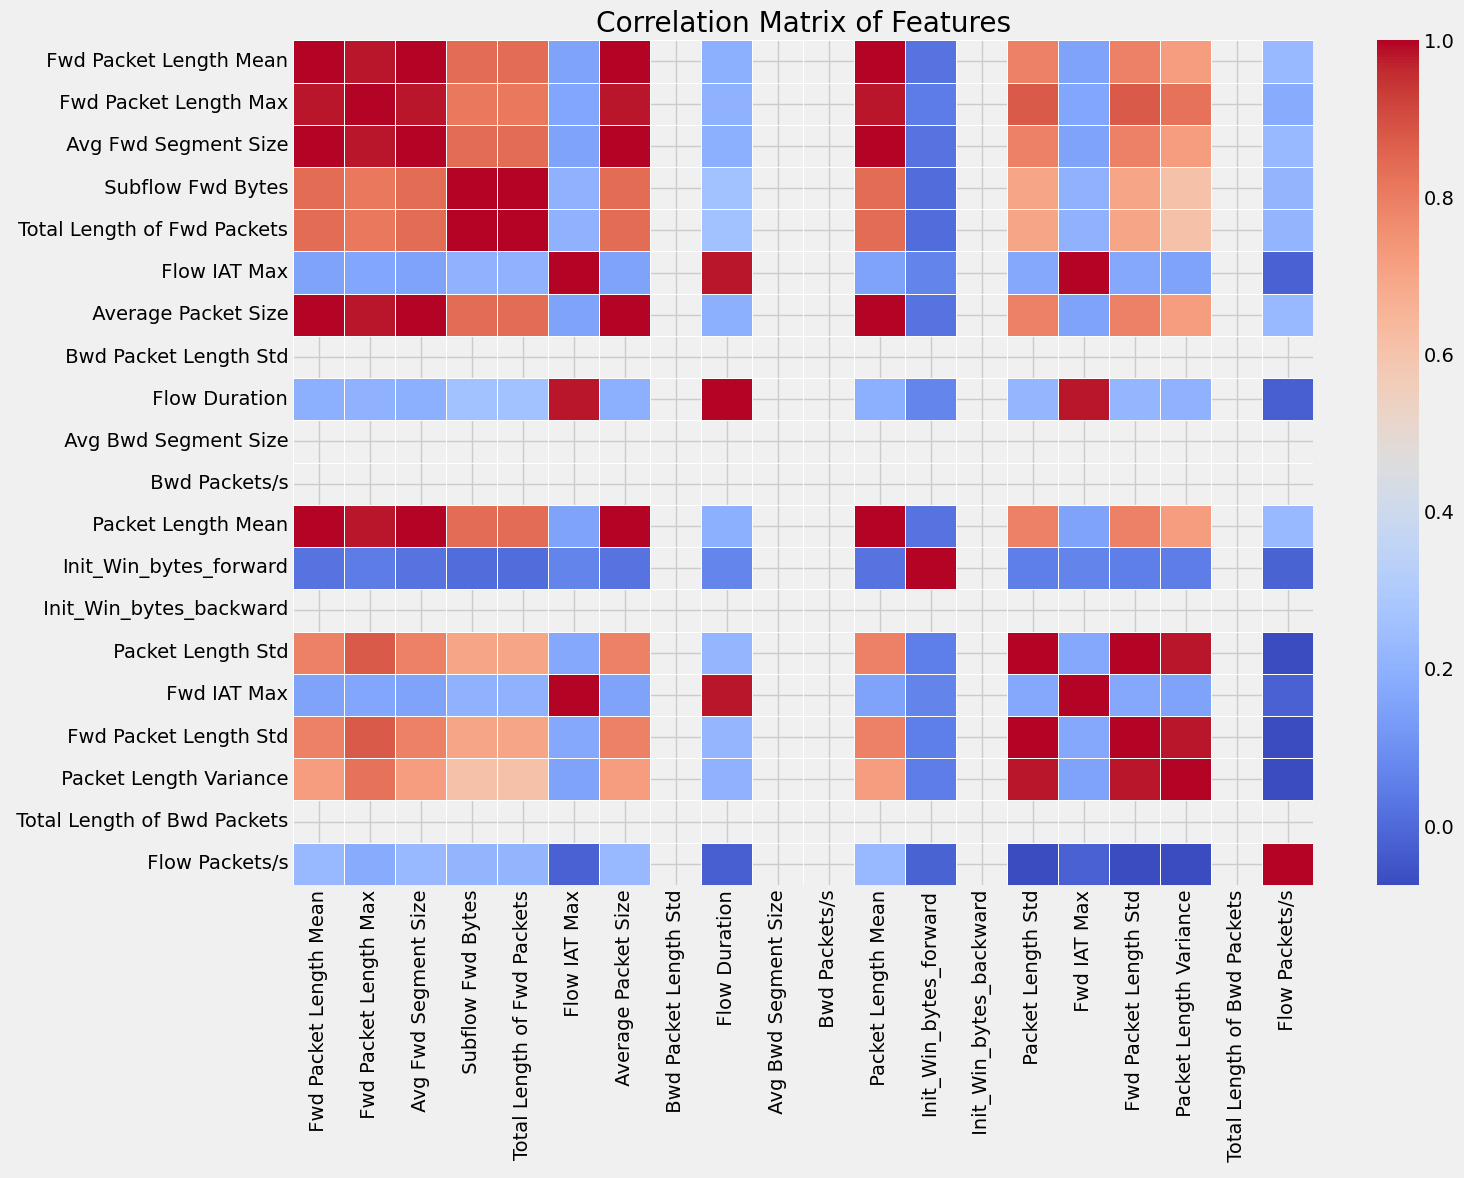

High correlation:  Fwd Packet Length Mean and  Fwd Packet Length Max: 0.98
High correlation:  Fwd Packet Length Mean and  Avg Fwd Segment Size: 1.00
High correlation:  Fwd Packet Length Max and  Avg Fwd Segment Size: 0.98
High correlation:  Subflow Fwd Bytes and Total Length of Fwd Packets: 1.00
High correlation:  Fwd Packet Length Mean and  Average Packet Size: 1.00
High correlation:  Fwd Packet Length Max and  Average Packet Size: 0.98
High correlation:  Avg Fwd Segment Size and  Average Packet Size: 1.00
High correlation:  Flow IAT Max and  Flow Duration: 0.98
High correlation:  Fwd Packet Length Mean and  Packet Length Mean: 1.00
High correlation:  Fwd Packet Length Max and  Packet Length Mean: 0.98
High correlation:  Avg Fwd Segment Size and  Packet Length Mean: 1.00
High correlation:  Average Packet Size and  Packet Length Mean: 1.00
High correlation:  Flow IAT Max and  Fwd IAT Max: 1.00
High correlation:  Flow Duration and  Fwd IAT Max: 0.98
High correlation:  Packet Length Std 

In [5]:
# 3. Exploratory Data Analysis")

# Basic statistics for numeric columns
print("\nBasic statistics:")
numeric_df = combined_df.select_dtypes(include=[np.number])
print(numeric_df.describe().T)

# Correlation analysis
print("\nCalculating correlations...")
plt.figure(figsize=(16, 12))
correlation = numeric_df.corr()
# mask = np.triu(correlation)
sns.heatmap(correlation, annot=False,  cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix of Features')
plt.tight_layout()
plt.show()

# Identify highly correlated features (|r| > 0.9)
high_corr_features = set()
for i in range(len(correlation.columns)):
    for j in range(i):
        if abs(correlation.iloc[i, j]) > 0.9:
            colname = correlation.columns[i]
            high_corr_features.add(colname)
            print(f"High correlation: {correlation.columns[j]} and {colname}: {correlation.iloc[i, j]:.2f}")

print(f"\nIdentified {len(high_corr_features)} highly correlated features")



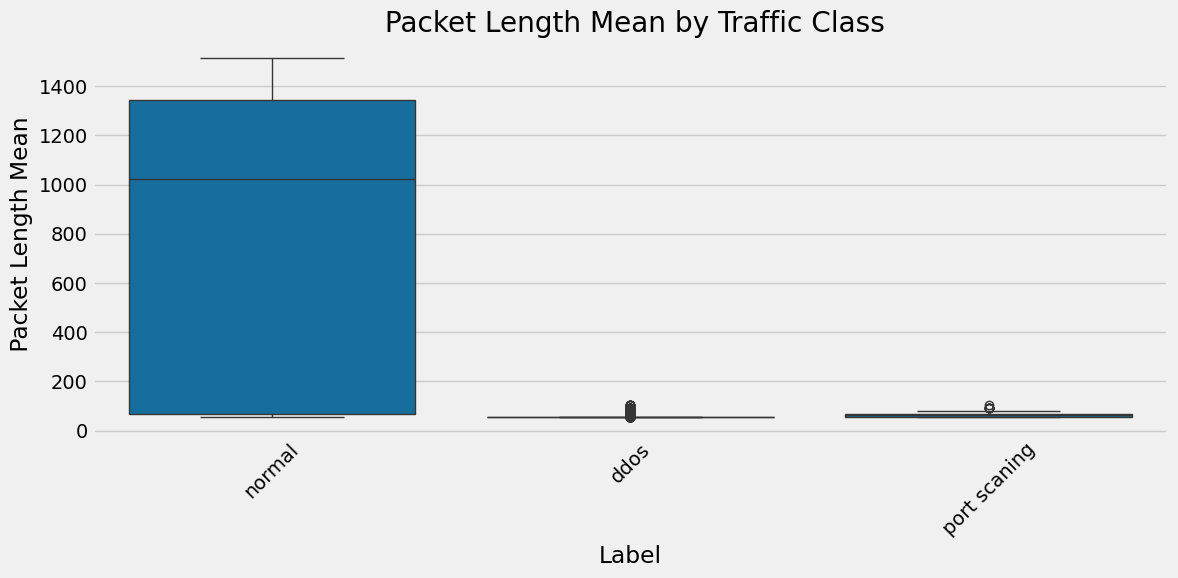

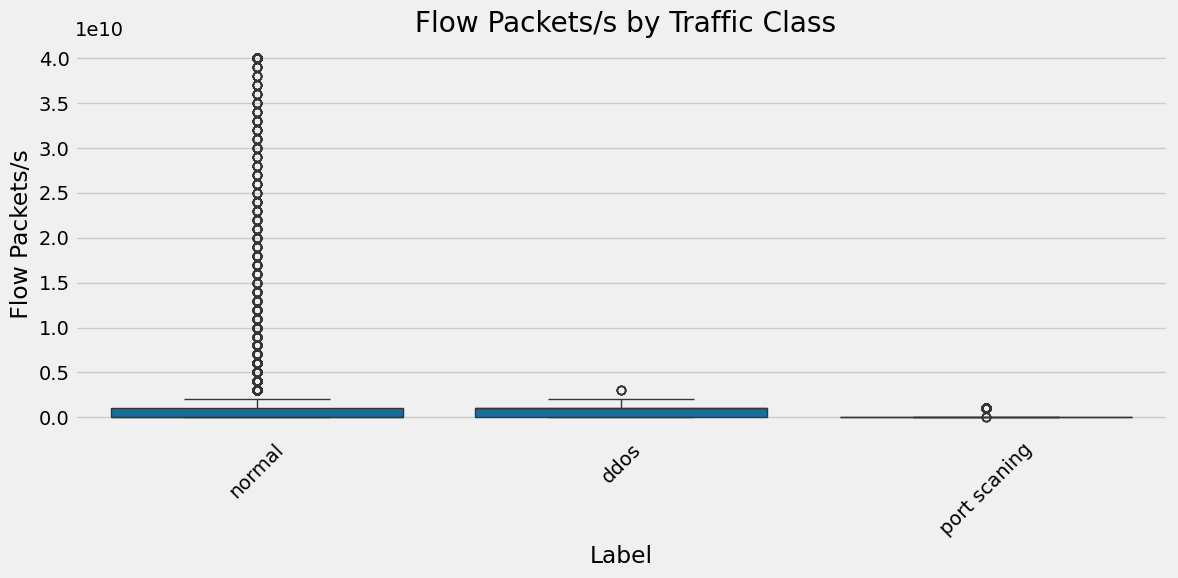

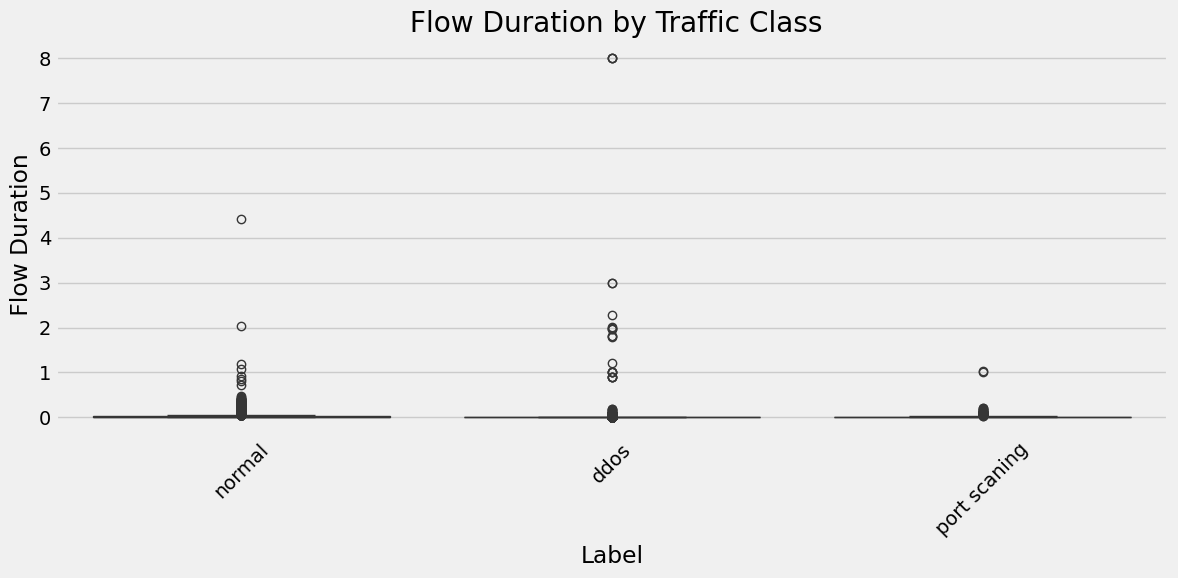

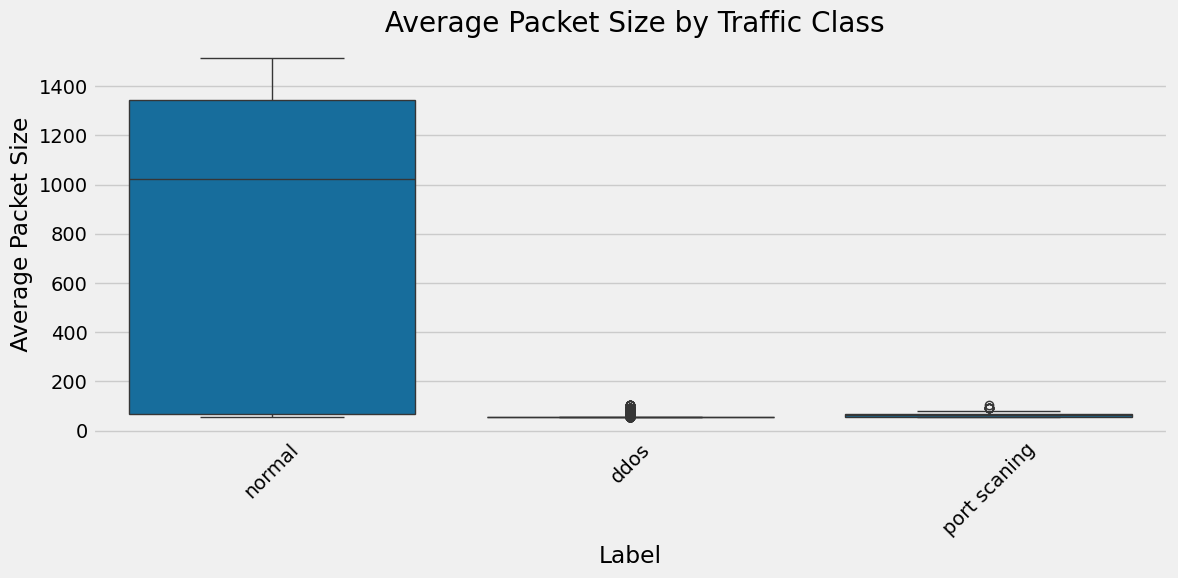

In [6]:
#Exploring feature distributions by class...")

# Select 4 important features to visualize
important_features = [
    ' Packet Length Mean',
    ' Flow Packets/s',
    ' Flow Duration',
    ' Average Packet Size'
]

for feature in important_features:
    if feature in combined_df.columns:
        plt.figure(figsize=(12, 6))
        sns.boxplot(x='Label', y=feature, data=combined_df)
        plt.title(f'{feature} by Traffic Class')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

In [7]:
# 4. Feature Selection and Engineering

# Separating features and target
X = combined_df.drop('Label', axis=1)
y = combined_df['Label']

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")

# Handle potential non-numeric columns
non_numeric = X.select_dtypes(exclude=[np.number]).columns
if len(non_numeric) > 0:
    print(f"\nNon-numeric columns found: {non_numeric.tolist()}")
    print("Converting or dropping non-numeric columns...")
    for col in non_numeric:
        # Try to convert to numeric if possible
        try:
            X[col] = pd.to_numeric(X[col])
            print(f"Converted {col} to numeric")
        except:
            print(f"Dropping column {col} as it cannot be converted to numeric")
            X = X.drop(col, axis=1)

# Print final feature set
print(f"\nFinal feature set shape: {X.shape}")
print(f"Feature names: {X.columns.tolist()}")

Features shape: (336464, 20)
Target shape: (336464,)

Final feature set shape: (336464, 20)
Feature names: [' Fwd Packet Length Mean', ' Fwd Packet Length Max', ' Avg Fwd Segment Size', ' Subflow Fwd Bytes', 'Total Length of Fwd Packets', ' Flow IAT Max', ' Average Packet Size', ' Bwd Packet Length Std', ' Flow Duration', ' Avg Bwd Segment Size', ' Bwd Packets/s', ' Packet Length Mean', 'Init_Win_bytes_forward', ' Init_Win_bytes_backward', ' Packet Length Std', ' Fwd IAT Max', ' Fwd Packet Length Std', ' Packet Length Variance', ' Total Length of Bwd Packets', ' Flow Packets/s']


In [8]:
# Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"Scaled features shape: {X_scaled.shape}")

Scaled features shape: (336464, 20)


In [9]:
# 5. Data Splitting

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.25, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape}, {y_train.shape}")
print(f"Testing set: {X_test.shape}, {y_test.shape}")

# Check training class distribution
print("\nTraining set class distribution:")
print(y_train.value_counts())

# Check test class distribution
print("\nTest set class distribution:")
print(y_test.value_counts())



Training set: (252348, 20), (252348,)
Testing set: (84116, 20), (84116,)

Training set class distribution:
Label
ddos            238759
normal           12952
port scaning       637
Name: count, dtype: int64

Test set class distribution:
Label
ddos            79586
normal           4318
port scaning      212
Name: count, dtype: int64


In [10]:
def train_evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    print(f"\n### Training {model_name}")
    
    # Train model (data already scaled)
    print("Training model...")
    model.fit(X_train, y_train)
    
    # Make predictions
    print("Making predictions...")
    y_pred = model.predict(X_test)
    
    # Evaluate
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.4f}")
    
    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    # Confusion Matrix
    print("\nConfusion Matrix:")
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=sorted(y.unique()), 
                yticklabels=sorted(y.unique()))
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.tight_layout()
    plt.show()
    
    return model, accuracy


 name = Decision Tree model = DecisionTreeClassifier(random_state=42)

### Training Decision Tree
Training model...
Making predictions...
Accuracy: 0.9968

Classification Report:
              precision    recall  f1-score   support

        ddos       1.00      1.00      1.00     79586
      normal       0.98      0.99      0.98      4318
port scaning       0.63      0.55      0.59       212

    accuracy                           1.00     84116
   macro avg       0.87      0.85      0.86     84116
weighted avg       1.00      1.00      1.00     84116


Confusion Matrix:


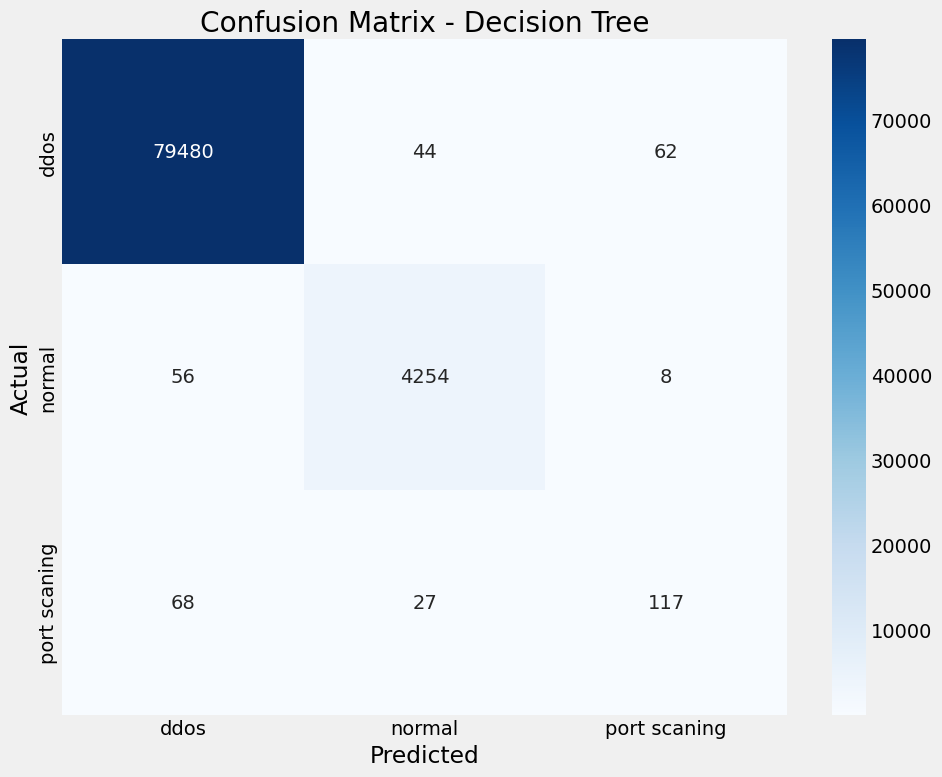


after training Decision Tree model = DecisionTreeClassifier(random_state=42)
Saved Decision Tree model to scapy_Decision Tree.pkl

 name = Random Forest model = RandomForestClassifier(random_state=42)

### Training Random Forest
Training model...
Making predictions...
Accuracy: 0.9971

Classification Report:
              precision    recall  f1-score   support

        ddos       1.00      1.00      1.00     79586
      normal       0.98      0.99      0.98      4318
port scaning       0.68      0.58      0.63       212

    accuracy                           1.00     84116
   macro avg       0.89      0.86      0.87     84116
weighted avg       1.00      1.00      1.00     84116


Confusion Matrix:


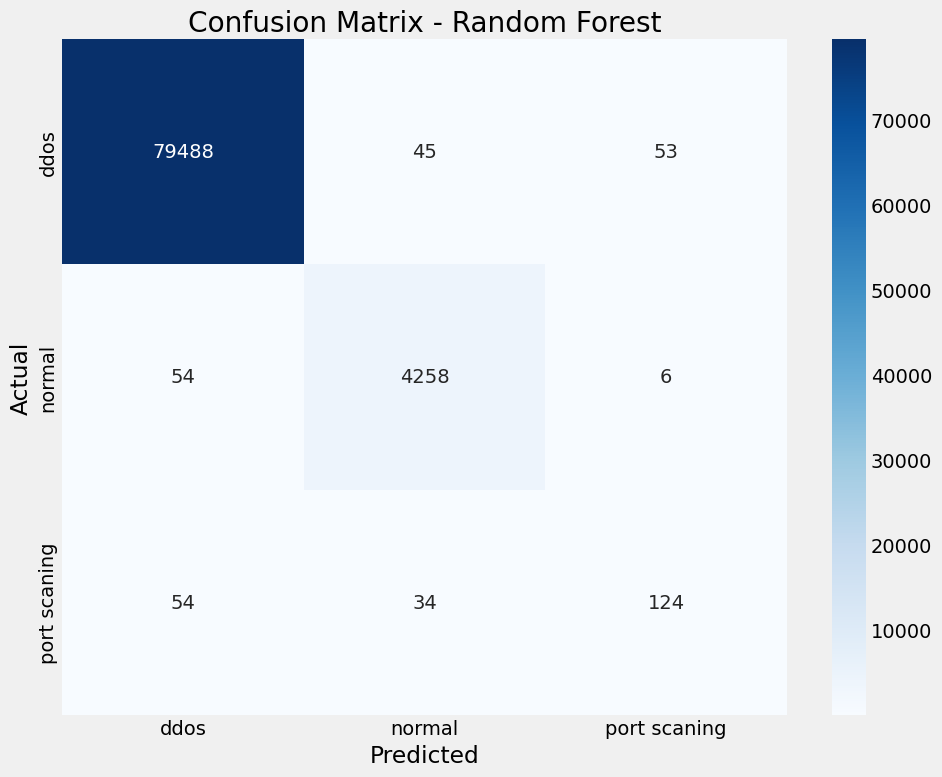


after training Random Forest model = RandomForestClassifier(random_state=42)
Saved Random Forest model to scapy_Random Forest.pkl

 name = KNN model = KNeighborsClassifier()

### Training KNN
Training model...
Making predictions...
Accuracy: 0.9966

Classification Report:
              precision    recall  f1-score   support

        ddos       1.00      1.00      1.00     79586
      normal       0.99      0.98      0.98      4318
port scaning       0.63      0.56      0.59       212

    accuracy                           1.00     84116
   macro avg       0.87      0.85      0.86     84116
weighted avg       1.00      1.00      1.00     84116


Confusion Matrix:


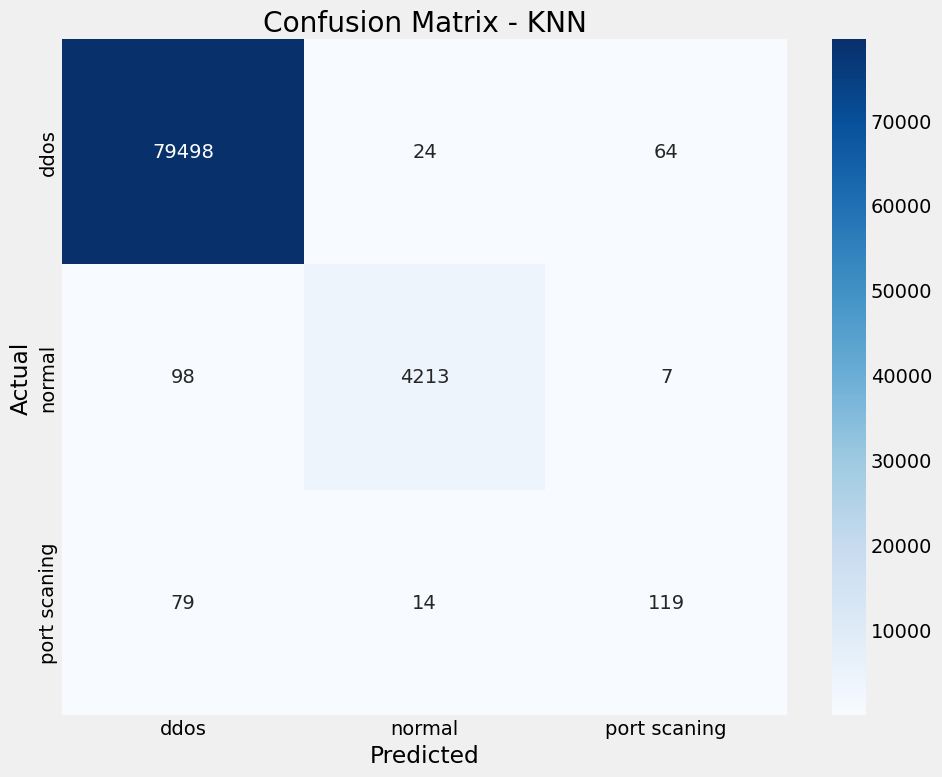


after training KNN model = KNeighborsClassifier()
Saved KNN model to scapy_KNN.pkl


In [11]:
models = {
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'KNN': KNeighborsClassifier()
}

results = {}

for name, model in models.items():
    print(f"\n name = {name} model = {model}")
    trained_model, accuracy = train_evaluate_model(model, X_train, X_test, 
                                                 y_train, y_test, name)
    print(f"\nafter training {name} model = {trained_model}")
    results[name] = {
        'model': trained_model,
        'accuracy': accuracy
    }
    joblib.dump(trained_model, f"scapy_{name.replace(' ','_')}.pkl")
    print(f"Saved {name} model to scapy_{name}.pkl")

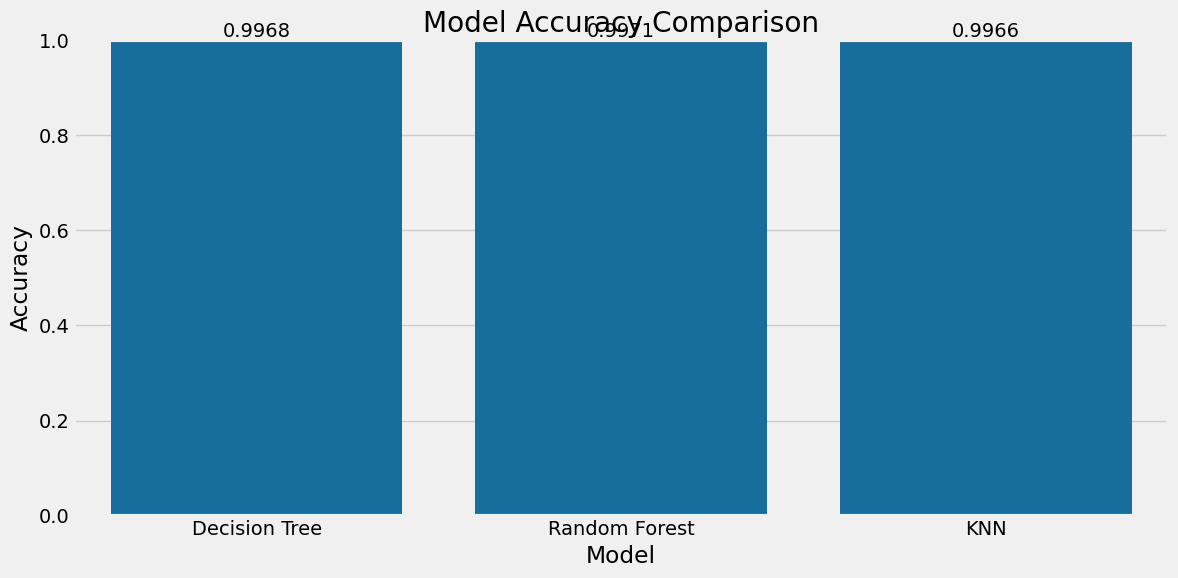

In [12]:
# 8. Model Comparison and Selection")

# Compare all models
# model_names = ['Decision Tree', 'Random Forest', 'KNN']
model_names = list(results.keys())
# accuracies = [0.9968,0.9970,0.9966]
accuracies = [results[name]['accuracy'] for name in model_names]
# Create comparison chart
plt.figure(figsize=(12, 6))
sns.barplot(x=model_names, y=accuracies)
plt.title('Model Accuracy Comparison')
plt.ylim(0, 1)
plt.ylabel('Accuracy')
plt.xlabel('Model')
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.01, f'{acc:.4f}', ha='center')
plt.tight_layout()
plt.show()

In [13]:
# save scaler
joblib.dump(scaler, 'scapy_scaler.pkl')

['scapy_scaler.pkl']

In [14]:
# load models 
model1 = joblib.load('scapy_Decision_Tree.pkl')

In [15]:
print(f"Loaded model: {model1}")

Loaded model: DecisionTreeClassifier(random_state=42)


In [ ]:
# load scaler
scaler = joblib.load('scapy_scaler.pkl')